In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv3D, Conv2D, Conv1D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')
import random

In [24]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

In [25]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.gif')]

In [26]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    print ("Maximum difference was %d" % (max_diff))
    
    return ela_im

In [27]:
fakes_datasets_filename = get_imlist('datasets/train/fake/')
reals_datasets_filename = get_imlist('datasets/train/real')

In [28]:
print(len(fakes_datasets_filename))
print(len(reals_datasets_filename))

1771
6868


# Starts Here

In [29]:
fake_imfile_list = []
for filename in fakes_datasets_filename[0:250]:
    fake_imfile_list.append(array(Image.open(filename).convert('L').resize((128, 128))).flatten())

In [30]:
real_imfile_list = []
for filename in reals_datasets_filename[0:250]:
    real_imfile_list.append(array(Image.open(filename).convert('L').resize((128, 128))).flatten())

In [31]:
len(fake_imfile_list)

250

In [32]:
len(real_imfile_list)

250

# Lanjut

In [33]:
for index, fake_imfile in enumerate(fake_imfile_list):
    fake_imfile_list[index] = fake_imfile / 255.0

In [34]:
for index, real_imfile in enumerate(real_imfile_list):
    real_imfile_list[index] = real_imfile / 255.0

# Change to Data Frame

## Extend and Delete

In [35]:
X = []
X.extend(fake_imfile_list)
X.extend(real_imfile_list)

In [36]:
len(X)

500

In [37]:
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.027451,0.027451,0.121569,0.180392,0.254902,0.298039,0.086275,0.145098,0.027451,0.039216,...,0.109804,0.200000,0.019608,0.039216,0.039216,0.043137,0.082353,0.054902,0.031373,0.027451
1,0.039216,0.050980,0.062745,0.047059,0.050980,0.047059,0.047059,0.082353,0.062745,0.062745,...,0.211765,0.215686,0.203922,0.203922,0.188235,0.196078,0.184314,0.188235,0.188235,0.176471
2,0.007843,0.027451,0.007843,0.070588,0.047059,0.141176,0.019608,0.235294,0.274510,0.294118,...,0.552941,0.549020,0.537255,0.537255,0.537255,0.525490,0.505882,0.505882,0.478431,0.435294
3,0.247059,0.407843,0.513725,0.560784,0.596078,0.678431,0.698039,0.690196,0.666667,0.635294,...,0.015686,0.066667,0.082353,0.137255,0.266667,0.066667,0.364706,0.447059,0.415686,0.407843
4,0.858824,0.843137,0.870588,0.850980,0.854902,0.850980,0.854902,0.858824,0.847059,0.854902,...,0.015686,0.000000,0.007843,0.015686,0.023529,0.019608,0.039216,0.074510,0.345098,0.266667
5,0.043137,0.043137,0.082353,0.070588,0.050980,0.047059,0.054902,0.062745,0.066667,0.054902,...,0.050980,0.035294,0.039216,0.141176,0.058824,0.078431,0.192157,0.101961,0.027451,0.019608
6,0.831373,0.835294,0.831373,0.827451,0.815686,0.796078,0.803922,0.752941,0.650980,0.596078,...,0.317647,0.294118,0.439216,0.298039,0.341176,0.505882,0.298039,0.505882,0.247059,0.278431
7,0.023529,0.015686,0.019608,0.054902,0.505882,0.764706,0.596078,0.129412,0.149020,0.164706,...,0.254902,0.227451,0.156863,0.145098,0.117647,0.109804,0.050980,0.082353,0.141176,0.094118
8,0.427451,0.427451,0.427451,0.439216,0.423529,0.415686,0.427451,0.435294,0.439216,0.439216,...,0.270588,0.572549,0.866667,0.745098,0.643137,0.654902,0.603922,0.705882,0.705882,0.690196
9,0.062745,0.058824,0.062745,0.058824,0.058824,0.054902,0.050980,0.050980,0.054902,0.050980,...,0.066667,0.070588,0.062745,0.050980,0.054902,0.058824,0.054902,0.066667,0.062745,0.054902


## Add Y

In [38]:
Y = []
for i in range(len(fake_imfile_list)):
    Y.append(1)
for i in range(len(real_imfile_list)):
    Y.append(0)

In [39]:
Y = to_categorical(Y, num_classes=2)

In [40]:
Y.shape

(500, 2)

# Reshape X

In [41]:
X = X.values.reshape(-1, 128, 128, 1)

In [42]:
X.shape

(500, 128, 128, 1)

## Train Test Split

In [43]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state=5)

In [44]:
X_val

array([[[[0.49019608],
         [0.35294118],
         [0.41176471],
         ...,
         [0.25882353],
         [0.2       ],
         [0.18039216]],

        [[0.54117647],
         [0.73333333],
         [0.14117647],
         ...,
         [0.24705882],
         [0.21176471],
         [0.18431373]],

        [[0.39607843],
         [0.43137255],
         [0.46666667],
         ...,
         [0.25098039],
         [0.19215686],
         [0.20392157]],

        ...,

        [[0.21960784],
         [0.19215686],
         [0.22352941],
         ...,
         [0.04313725],
         [0.04705882],
         [0.06666667]],

        [[0.28627451],
         [0.2627451 ],
         [0.29803922],
         ...,
         [0.04705882],
         [0.05098039],
         [0.0627451 ]],

        [[0.34901961],
         [0.21176471],
         [0.23529412],
         ...,
         [0.05490196],
         [0.05490196],
         [0.07058824]]],


       [[[0.29803922],
         [0.31372549],
         [0.32

# Model

In [57]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [58]:
optimizer = SGD(lr=0.01, momentum=0.99, decay=0.0005)
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [59]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


In [60]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [61]:
epochs = 200
batch_size = 100

In [ ]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Train on 450 samples, validate on 50 samples
Epoch 1/200
 - 5s - loss: 0.6919 - acc: 0.5044 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 2/200
 - 1s - loss: 0.6910 - acc: 0.5289 - val_loss: 0.6903 - val_acc: 0.5800
Epoch 3/200
 - 1s - loss: 0.6987 - acc: 0.5067 - val_loss: 0.6924 - val_acc: 0.5200
Epoch 4/200
 - 1s - loss: 0.6937 - acc: 0.5267 - val_loss: 0.6970 - val_acc: 0.5000
Epoch 5/200
 - 1s - loss: 0.6966 - acc: 0.5000 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 6/200
 - 1s - loss: 0.6914 - acc: 0.5356 - val_loss: 0.6917 - val_acc: 0.5400
Epoch 7/200
 - 1s - loss: 0.6886 - acc: 0.5378 - val_loss: 0.6916 - val_acc: 0.5400
Epoch 8/200
 - 1s - loss: 0.6846 - acc: 0.5356 - val_loss: 0.6903 - val_acc: 0.4800
Epoch 9/200
 - 1s - loss: 0.6749 - acc: 0.5889 - val_loss: 0.6859 - val_acc: 0.5600
Epoch 10/200
 - 1s - loss: 0.6673 - acc: 0.5889 - val_loss: 0.6876 - val_acc: 0.5000
Epoch 11/200
 - 2s - loss: 0.6557 - acc: 0.5933 - val_loss: 0.7092 - val_acc: 0.5200
Epoch 12/200
 - 2s - loss: 0.

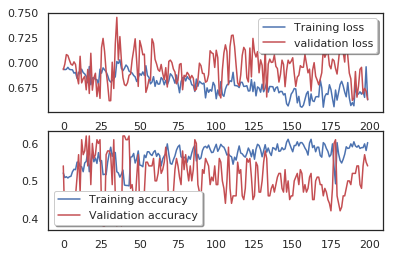

In [29]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

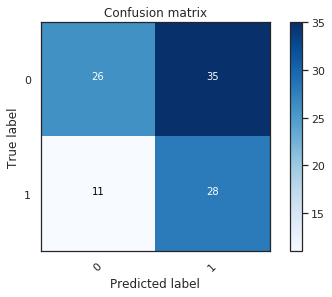

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2)) 
